In [11]:
#!pip install proglearn
#!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
#!unzip /content/ISIC2018_Task1-2_Training_Input.zip
#!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
#!unzip /content/ISIC2018_Task1_Training_GroundTruth.zip
print('Output of downloading data is omitted')

Output of downloading data is omitted


In [17]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from proglearn import LifelongClassificationNetwork
from proglearn import NeuralClassificationTransformer
from proglearn import KNNClassificationVoter
from proglearn import SimpleArgmaxAverage

In [3]:
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [4]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_path_correct = ''
        self.mask_path_correct = ''
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "ISIC2018_Task1-2_Training_Input", id_name) + ".jpg"
        mask_path = os.path.join(self.path, "ISIC2018_Task1_Training_GroundTruth", id_name) + "_segmentation.png"
        
        ## Reading Image
        try:
            image = cv2.imread(image_path,1)
            image = cv2.resize(image, (self.image_size, self.image_size))
            mask = np.zeros((self.image_size, self.image_size, 1))
            _mask = cv2.imread(mask_path, -1)
            _mask = cv2.resize(_mask, (self.image_size, self.image_size))
            _mask = np.expand_dims(_mask, axis=-1)
            mask = np.maximum(mask, _mask)
            
            
            ## Normalizaing 
            image = image/255.0
            mask = mask/255.0
            self.img_path_correct = image_path
            self.mask_path_correct = mask_path
            return image, mask
        except:
            if self.img_path_correct != '':
                image = cv2.imread(self.img_path_correct,1)
                
                image = cv2.resize(image, (self.image_size, self.image_size))
                image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
                mask = np.zeros((self.image_size, self.image_size, 1))
                
                _mask = cv2.imread(self.mask_path_correct, -1)
                _mask = cv2.resize(_mask, (self.image_size, self.image_size))
                _mask = np.expand_dims(_mask, axis=-1)
                mask = np.maximum(mask, _mask)
                mask = cv2.rotate(mask, cv2.cv2.ROTATE_90_CLOCKWISE)
                
                
                ## Normalizaing 
                image = image/255.0
                mask = mask/255.0
                return image, mask
            else:
                image = np.ones((self.image_size, self.image_size))
                mask = np.ones((self.image_size, self.image_size))
                ## Normalizaing 
                image = image/255.0
                mask = mask/255.0
                
                return image, mask

    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [5]:
image_size = 128
path = "./"
train_path = "./ISIC2018_Task1-2_Training_Input"
epochs = 1
batch_size = 19

## Training Ids
train_ids = []
for files in os.walk(train_path):
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]
train_ids = [i.split('.', 1)[0] for i in train_ids]
val_data_size = 171

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [6]:
gen = DataGen(train_ids, path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(19, 128, 128, 3) (19, 128, 128, 1)


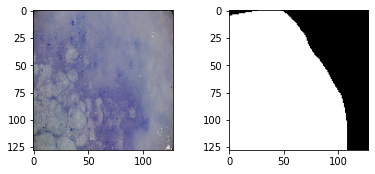

In [7]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [8]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [9]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3]) 
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [16]:
model = UNet()
lcn = LifelongClassificationNetwork(model, loss='binary_crossentropy', epochs=epochs, batch_size=batch_size)
lcn
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [20]:
transformer = lcn.default_transformer_class
transformer == NeuralClassificationTransformer

True

In [21]:
voter = lcn.default_voter_class 
voter == KNNClassificationVoter

True

In [22]:
decider = lcn.default_decider_class
decider == SimpleArgmaxAverage

True

In [48]:
def test_predict_without_fit(image_path, lcn):
    X = np.array(cv2.imread(img_path, 0))
    X = np.tile(X, (100, 1, 1))
    lcn.predict(X, task_id=10)

In [51]:
# intentially trigger Not Fitted Error
img_path = 'ISIC2018_Task1-2_Training_Input/ISIC_0013494.jpg'
test_predict_without_fit(img_path, lcn)

NotFittedError: ignored

array([[47, 47, 47, ..., 21, 21, 24],
       [49, 46, 45, ..., 21, 22, 24],
       [47, 46, 44, ..., 21, 23, 24],
       ...,
       [18, 18, 18, ..., 32, 32, 29],
       [17, 17, 18, ..., 33, 35, 34],
       [17, 17, 17, ..., 35, 39, 43]], dtype=uint8)

In [ ]:
train_gen = DataGen(train_ids, path)
valid_gen = DataGen(valid_ids, path)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs = epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


127/127 [==============================] - 247s 2s/step - loss: 0.4141 - acc: 0.8092 - val_loss: 0.2430 - val_acc: 0.9147


In [ ]:
## Save the Weights
model.save_weights("UNetW1.h5")

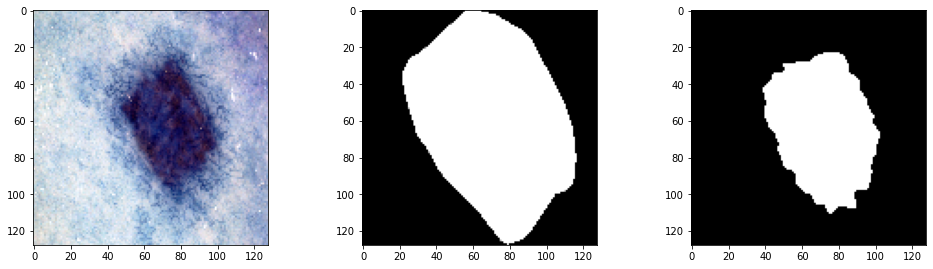

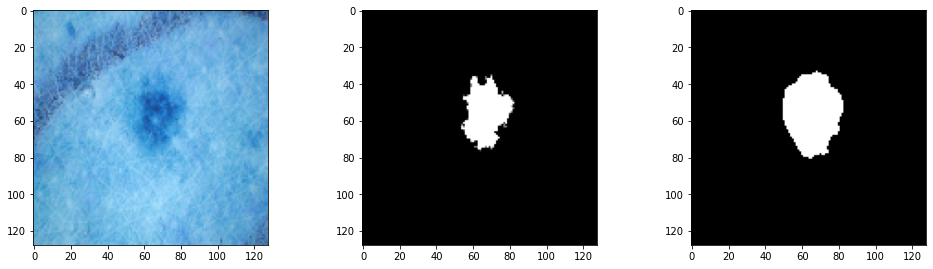

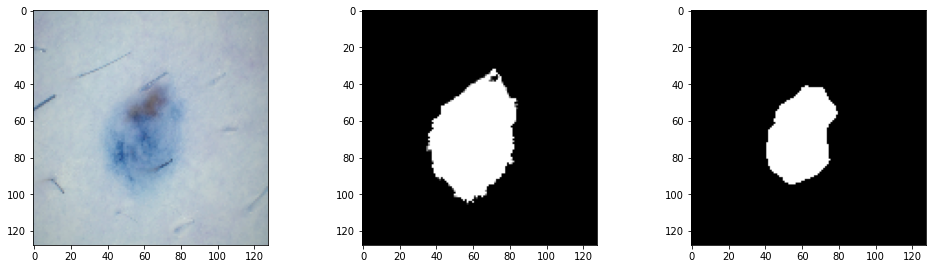

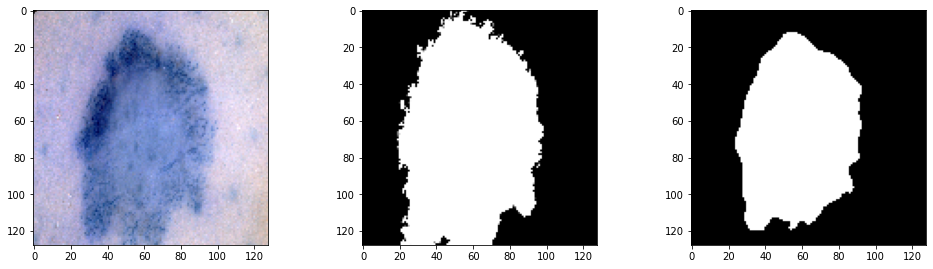

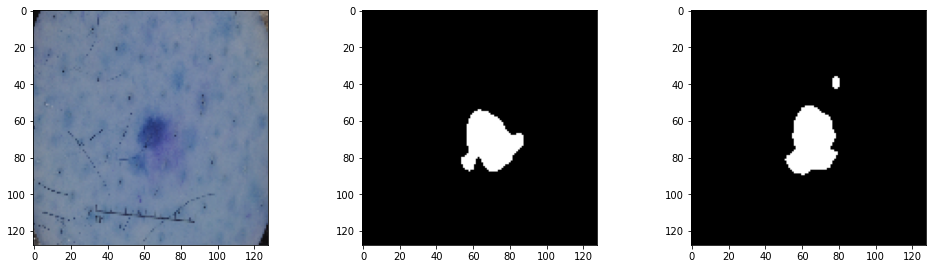

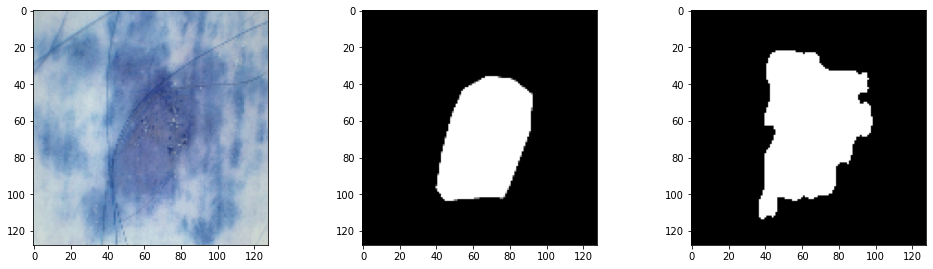

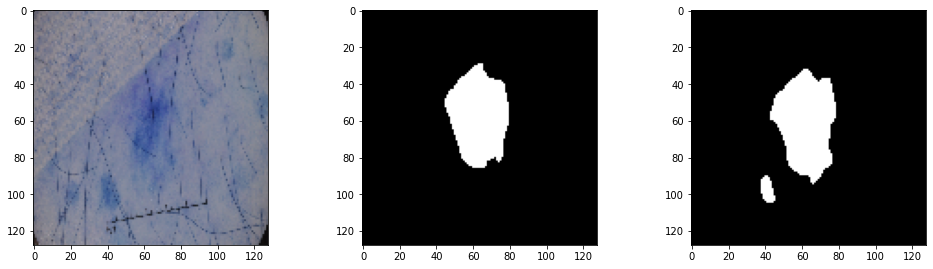

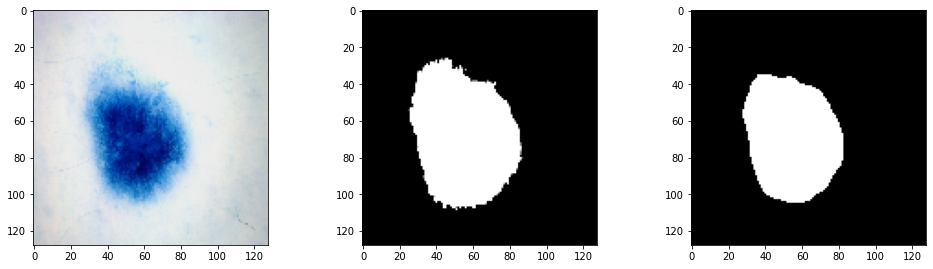

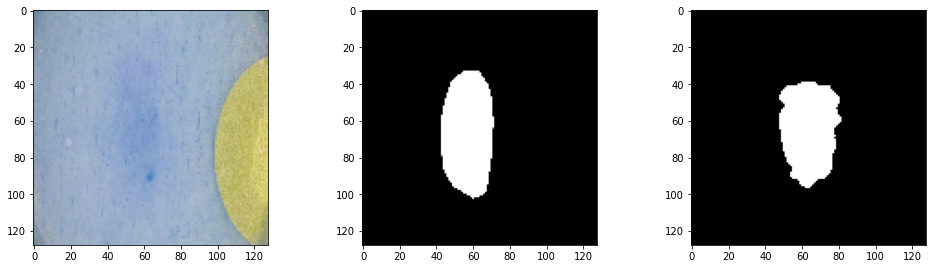

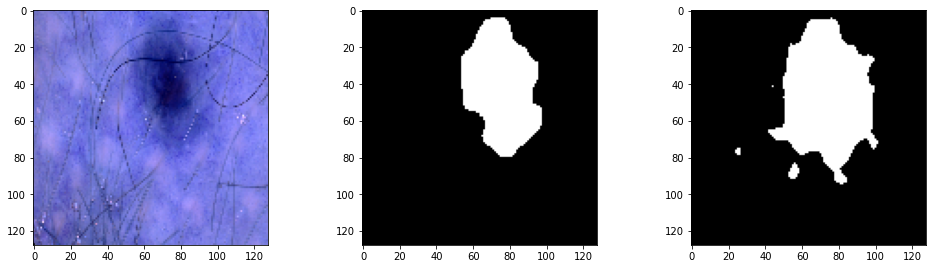

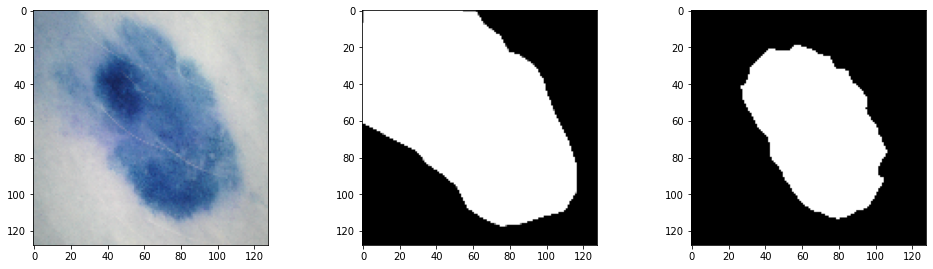

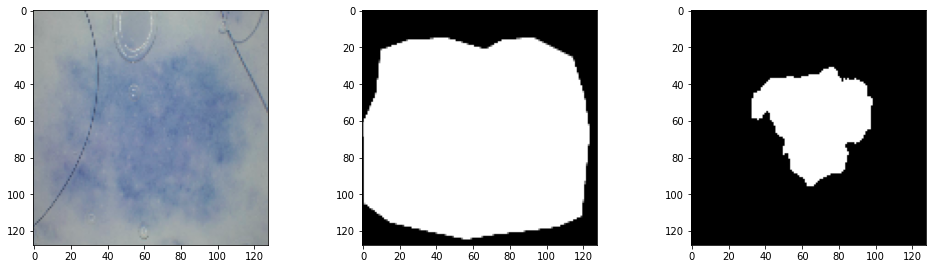

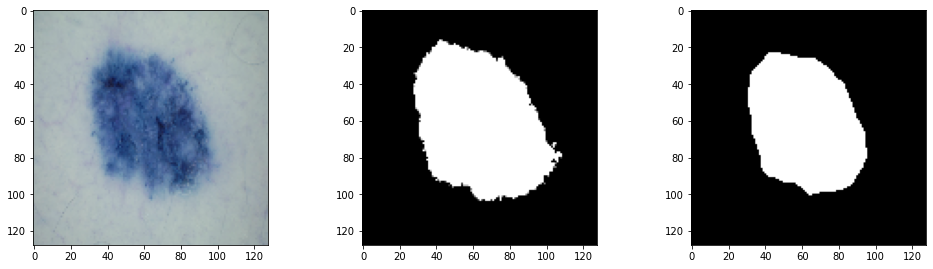

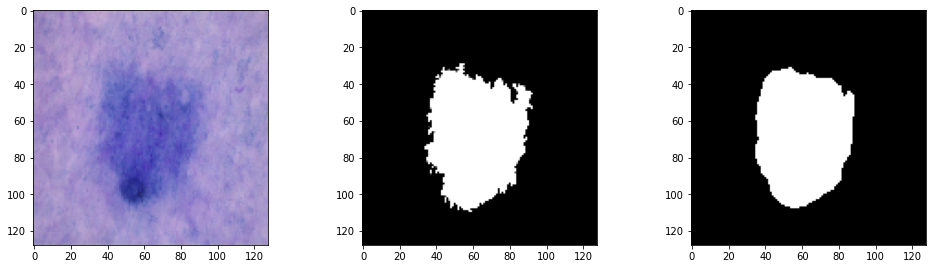

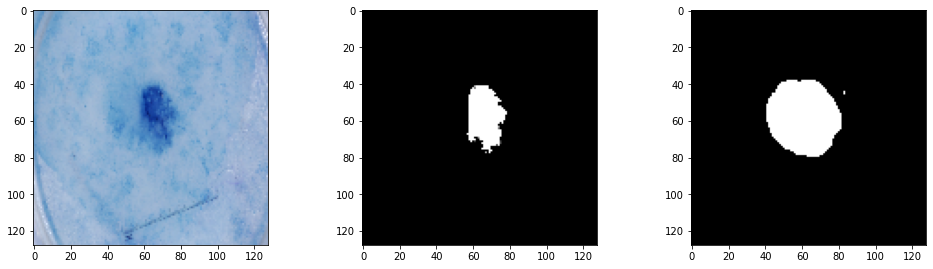

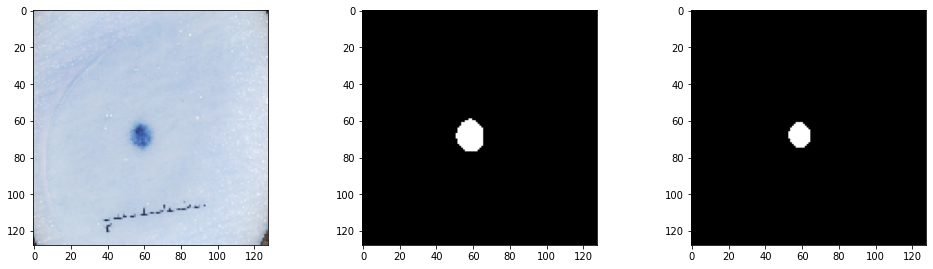

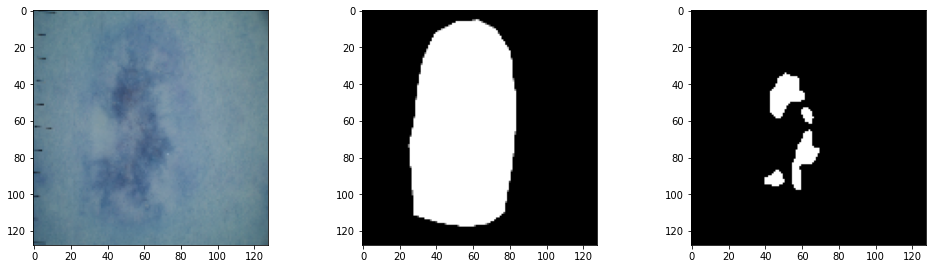

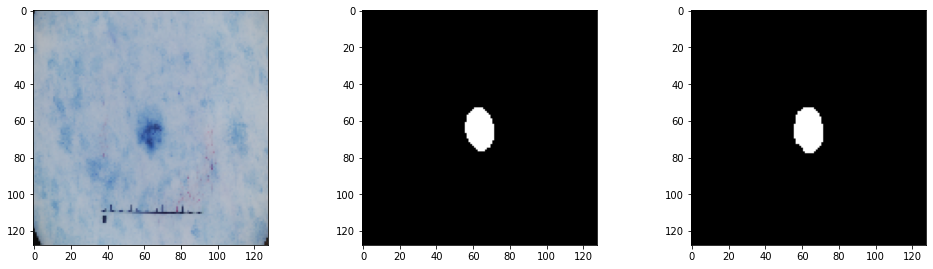

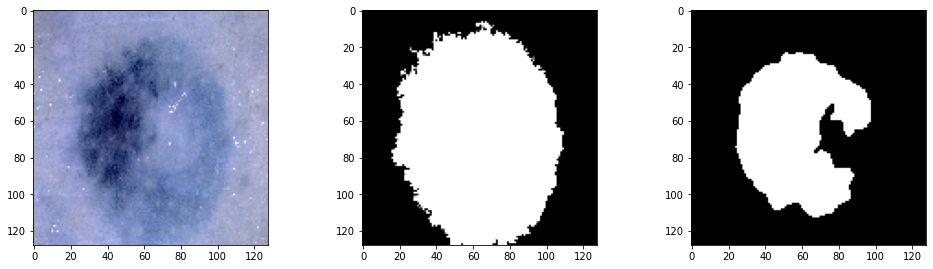

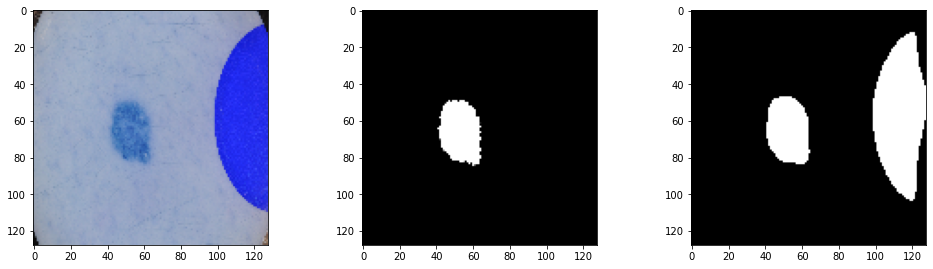

In [ ]:
for i in range(0,20):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")
